In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import os
import numpy as np
#import ta
import pandas as pd
import matplotlib.pyplot as plt
#import talib
#!pip install ta
#!pip install --upgrade yfinance
#!pip install mplfinance

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
#import mplfinance as mpf
import ta
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands

# ✅ Fetch 1-Minute Data for NIFTY 50
nifty = "GODREJCP.NS"  #  #"^NSEBANK" 50 Index  ^NSEI
df = yf.download(nifty, period="5d", interval="5m")
df.columns = df.columns.get_level_values(0)

# ✅ Convert Timezone to IST
df.index = df.index.tz_convert("Asia/Kolkata")

# ✅ Aggregate to 3-Minute Intervals
df_3min = df.resample("2min").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()

# ✅ Calculate EMAs
df_3min["EMA_5"] = round(df_3min["Close"].ewm(span=5, adjust=False).mean())
df_3min["EMA_7"] = round(df_3min["Close"].ewm(span=7, adjust=False).mean())
df_3min["EMA_10"] =round(df_3min["Close"].ewm(span=10, adjust=False).mean())
df_3min["EMA_20"] =round(df_3min["Close"].ewm(span=20, adjust=False).mean())
df_3min["EMA_50"] =round(df_3min["Close"].ewm(span=50, adjust=False).mean())
df_3min["Pivot"] = (df_3min["High"] + df_3min["Low"] + df_3min["Close"]) / 3
df_3min["EMA_200"] =round(df_3min["Close"].ewm(span=200, adjust=False).mean())
df_3min["Close"]=round(df_3min["Close"])
df_3min["Open"]=round(df_3min["Open"])
df_3min["Variance"] =round(df_3min["Close"].rolling(window=10).var())
variance_threshold = round( df_3min["Variance"].mean() * 1.5,2)
df_3min["Var_Th"]=variance_threshold
df_3min["High"]=round(df_3min["High"])
df_3min["Low"]=round(df_3min["Low"])

# ✅ ATR Calculation
def atr(df, period=10):
    high_low = df["High"] - df["Low"]
    high_close = np.abs(df["High"] - df["Close"].shift(1))
    low_close = np.abs(df["Low"] - df["Close"].shift(1))
    tr = np.maximum(high_low, np.maximum(high_close, low_close))
    return tr.rolling(period).mean()

# ✅ Supertrend Calculation
def supertrend(df, period=10, multiplier=3):
    df["ATR"] = atr(df, period)
    hl2 = (df["High"] + df["Low"]) / 2
    df["Upper_Band"] = hl2 + (multiplier * df["ATR"])
    df["Lower_Band"] = hl2 - (multiplier * df["ATR"])
    df["Supertrend"] = np.nan
    uptrend = True

    for i in range(1, len(df)):
        if df["Close"].iloc[i] > df["Upper_Band"].iloc[i-1]:
            uptrend = True
        elif df["Close"].iloc[i] < df["Lower_Band"].iloc[i-1]:
            uptrend = False

        df.loc[df.index[i], "Supertrend"] = df["Lower_Band"].iloc[i] if uptrend else df["Upper_Band"].iloc[i]

    return df

df_3min = supertrend(df_3min)




lookback=14
# ✅ Compute RSI, MACD
df_3min["RSI"] = round(ta.momentum.rsi(df_3min["Close"], window=14))
df_3min["MACD"] = ta.trend.macd(df_3min["Close"])
df_3min["MACD_Signal"] = ta.trend.macd_signal(df_3min["Close"])

df_3min["HH"] = df_3min["High"].rolling(window=lookback).max()
df_3min["LL"] = df_3min["Low"].rolling(window=lookback).min()

# ✅ Compute Bollinger Bands
bb = BollingerBands(close=df_3min["Close"], window=20, window_dev=2)
df_3min["Upper_BB"] = bb.bollinger_hband()
df_3min["Lower_BB"] = bb.bollinger_lband()

# ✅ Compute ADX and Directional Indicators
adx = ADXIndicator(high=df_3min["High"], low=df_3min["Low"], close=df_3min["Close"], window=14)
df_3min["ADX"] = round(adx.adx())
df_3min["+DI"] = round( adx.adx_pos(),2)
df_3min["-DI"] =round(adx.adx_neg(),2)

# ✅ Detect ADX Increasing for the Last 5 Candles
df_3min["ADX_Incr"] = df_3min["ADX"].diff(5) > 0
df_3min["ADX_Decreasing"] = df_3min["ADX"].diff(5) < 0
df_3min['DI_Diff'] = abs(df_3min['+DI'] - df_3min['-DI'])  # Compute absolute difference

# ✅ Compute Pivot Points
df_3min["Pivot"] = (df_3min["High"] + df_3min["Low"] + df_3min["Close"]) / 3
df_3min["R1"] = round((2 * df_3min["Pivot"]) - df_3min["Low"], 0)
df_3min["S1"] = round((2 * df_3min["Pivot"]) - df_3min["High"], 0)
df_3min["R2"] = round(df_3min["Pivot"] + (df_3min["High"] - df_3min["Low"]), 0)
df_3min["S2"] = round(df_3min["Pivot"] - (df_3min["High"] - df_3min["Low"]), 0)
df_3min["Golden_Cross"] = (df_3min["EMA_20"] > df_3min["EMA_50"]) & (df_3min["EMA_20"].shift(1) < df_3min["EMA_50"].shift(1))
df_3min["Death_Cross"] = (df_3min["EMA_20"] < df_3min["EMA_50"]) & (df_3min["EMA_20"].shift(1) > df_3min["EMA_50"].shift(1))
df_3min["Golden/Death"] = np.where(df_3min["EMA_20"] > df_3min["EMA_50"],
                             np.where(df_3min["EMA_20"].shift(1) < df_3min["EMA_50"].shift(1), "BUY", "No Signal"),
                             np.where(df_3min["EMA_20"].shift(1) > df_3min["EMA_50"].shift(1), "SELL", "No Signal"))
df_3min["PriceAction-Buy"]=(df_3min["Close"] > df_3min["Open"]) & (df_3min["Open"].shift(1) > df_3min["Close"].shift(1)) & (df_3min["Close"] > df_3min["Open"].shift(1)) & (df_3min["Open"] < df_3min["Close"].shift(1))



df_3min["PriceAction_Sell"] = (
        (df_3min["Close"] < df_3min["Open"]) &
        (df_3min["Open"].shift(1) < df_3min["Close"].shift(1)) &
        (df_3min["Close"] < df_3min["Open"].shift(1)) &
        (df_3min["Open"] > df_3min["Close"].shift(1))
    )
df_3min["Doji"] = (
        abs(df_3min["Close"] - df_3min["Open"]) / df_3min["Open"] < 0.1
    )

df_3min["Price"] = "WAIT"

def detect_swing_highs_lows3(df, lookback=5):
    df['Swing_High'] = np.nan
    df['Swing_Low'] = np.nan

    for i in range(lookback, len(df) - lookback):
        if df['High'].iloc[i] > df['High'].iloc[i - lookback:i].max() and df['High'].iloc[i] > df['High'].iloc[i + 1:i + 1 + lookback].max():
            df.at[df.index[i], 'Swing_High'] = round(df['High'].iloc[i], 0)

        if df['Low'].iloc[i] < df['Low'].iloc[i - lookback:i].min() and df['Low'].iloc[i] < df['Low'].iloc[i + 1:i + 1 + lookback].min():
            df.at[df.index[i], 'Swing_Low'] = round(df['Low'].iloc[i], 0)

    return df






# Step 1: Detect Swing Highs and Lows
def detect_swing_highs_lows(df, lookback=2):
    df = df.copy()
    df['Swing_High'] = np.nan
    df['Swing_Low'] = np.nan

    for i in range(lookback, len(df) - lookback):
        window_highs = df['High'].iloc[i - lookback:i + lookback + 1]
        window_lows = df['Low'].iloc[i - lookback:i + lookback + 1]

        center = i

        if df['High'].iloc[center] == window_highs.max():
            df.at[df.index[center], 'Swing_High'] = round(df['High'].iloc[center], 2)

        if df['Low'].iloc[center] == window_lows.min():
            df.at[df.index[center], 'Swing_Low'] = round(df['Low'].iloc[center], 2)

    return df


# Step 2: Extract Support/Resistance Levels
def extract_sr_levels_from_swings(df, lookback=2, tolerance=0.5):
    swing_highs = df['Swing_High'].dropna().tail(lookback)
    swing_lows = df['Swing_Low'].dropna().tail(lookback)

    resistance_levels = []
    support_levels = []

    for price in swing_highs:
        if not any(abs(price - existing) <= tolerance for existing in resistance_levels):
            resistance_levels.append(price)

    for price in swing_lows:
        if not any(abs(price - existing) <= tolerance for existing in support_levels):
            support_levels.append(price)

    resistance_levels.sort(reverse=True)
    support_levels.sort()

    return resistance_levels, support_levels


# Step 3: Apply to your DataFrame (df_3min assumed to be your 3-minute interval data)
df_3min = detect_swing_highs_lows(df_3min, lookback=2)
res_levels, sup_levels = extract_sr_levels_from_swings(df_3min, lookback=2, tolerance=0.5)

# Step 4: Assign the most recent levels to the latest row
df_3min.loc[df_3min.index[-1], "res_level"] = res_levels[0] if res_levels else np.nan
df_3min.loc[df_3min.index[-1], "sup_level"] = sup_levels[0] if sup_levels else np.nan

df_3min["S-R"] = df_3min.apply(
    lambda row: f"{round(row['res_level'], 0)} - {round(row['sup_level'], 0)}"
    if pd.notna(row['res_level']) and pd.notna(row['sup_level']) else np.nan,
    axis=1
)

# # Set "BUY" signal where the PriceAction-Buy condition is True
df_3min.loc[df_3min["PriceAction-Buy"] == True, "Signal"] = "BUY"

# # Set "SELL" signal where the PriceAction-Sell condition is True, but only if "BUY" is not already set
# df_3min.loc[(df_3min["PriceAction_Sell"] == True) & (df_3min["Signal"] != "BUY"), "Signal"] = "SELL"

# # Set "WAIT" signal where Doji condition is True, but only if no other signal is present
df_3min.loc[(df_3min["Doji"] == True) & (df_3min["Signal"] == "WAIT"), "Signal"] = "WAIT"
# df_3min['Date'] = pd.to_datetime(df_3min['Datetime'])
# df_3min['Date'] = pd.to_datetime(df_3min['Datetime']).dt.date
df_3min["HA_Close"] = (df_3min["Open"] + df_3min["High"] + df_3min["Low"] + df_3min["Close"]) / 4
df_3min["HA_Open"] = df_3min["HA_Close"].shift(1)
#fillna(df_3min["Close"].iloc[0])
df_3min["HA_Open"].fillna(df_3min["Close"].iloc[0])
df_3min["HA_High"] = df_3min[["High", "HA_Open", "HA_Close"]].max(axis=1)
df_3min["HA_Low"] = df_3min[["Low", "HA_Open", "HA_Close"]].min(axis=1)

df_3min["HA_Bullish"] = (df_3min["HA_Close"] > df_3min["HA_Open"]) & \
                        (df_3min["HA_Low"] == df_3min[["HA_Open", "HA_Close", "Low"]].min(axis=1))

df_3min["HA_Bearish"] = (df_3min["HA_Close"] < df_3min["HA_Open"]) & \
                        (df_3min["HA_High"] == df_3min[["HA_Open", "HA_Close", "High"]].max(axis=1))

df_3min["HA_Signal"] = np.where(df_3min["HA_Bullish"], "BUY-HA",
                        np.where(df_3min["HA_Bearish"], "SELL-HA", ""))

df_3min['Bullish_Engulfing'] = (df_3min['Close'].shift(1) < df_3min['Open'].shift(1)) & (df_3min['Close'] > df_3min['Open']) & (df_3min['Close'] > df_3min['Open'].shift(1)) & (df_3min['Open'] < df_3min['Close'].shift(1))
df_3min['Bearish_Engulfing'] = (df_3min['Close'].shift(1) > df_3min['Open'].shift(1)) & (df_3min['Close'] < df_3min['Open']) & (df_3min['Close'] < df_3min['Open'].shift(1)) & (df_3min['Open'] > df_3min['Close'].shift(1))
df_3min['ADXPrice_BUY'] = (df_3min['ADX'] > 25) & (df_3min['Bullish_Engulfing'])
df_3min['ADXPrice_SELL'] = (df_3min['ADX'] > 25) & (df_3min['Bearish_Engulfing'])
# df_3min['ADXPrice'] = np.where((df_3min['ADX'] > 25) & (df_3min['Bullish_Engulfing']), 'BUY-Bullish_Engulfing',
#                              np.where((df_3min['ADX'] > 25) & (df_3min['Bearish_Engulfing']), 'SELL-Bearish_Engulfing', ''))
df_3min['ADXPrice'] = np.where(
    df_3min['Bullish_Engulfing'], 'BUY-Bullish_Engulfing',
    np.where(df_3min['Bearish_Engulfing'], 'SELL-Bearish_Engulfing', '')
)

# ✅ Compute SMHT (Standardized MACD Heikin-Ashi Transformed)
df_3min["SMHT"] = (df_3min["MACD"] - df_3min["MACD"].rolling(window=10).mean()) / df_3min["MACD"].rolling(window=10).std()

# ✅ Buy/Sell Ranges
df_3min["Buy_Range"] = df_3min["S1"]  # Buying near S1
df_3min["Sell_Range"] = df_3min["R1"]  # Selling near R1

# Candle parameters
df_3min["Candle_Body"] = abs(df_3min["Close"] - df_3min["Open"])
df_3min["Prev_Candle_Body"] = df_3min["Candle_Body"].shift(1)
df_3min["Is_Bullish"] = df_3min["Close"] > df_3min["Open"]
df_3min["Is_Bearish"] = df_3min["Close"] < df_3min["Open"]


def generate_signals_with_dynamic_ranges(data):
    signals, scores, entries, targets, stops, rr_ratios = [], [], [], [], [], []

    for i in range(len(data)):
        row = data.iloc[i]
        close = row["Close"]
        open_ = row['Open']
        adx = row["ADX"]
        prev_row = data.iloc[i - 1]
        plus_di, minus_di = row["+DI"], row["-DI"]
        candle_body = row["Candle_Body"]
        prev_body = row["Prev_Candle_Body"]
        prev_close = prev_row["Close"]
        prev_high = prev_row["High"]
        prev_low = prev_row["Low"]
        variance = row["Variance"]
        supertrend = row["Supertrend"]
        ema5, ema10, ema20, ema50, ema200 = row["EMA_5"], row["EMA_10"], row["EMA_20"], row["EMA_50"], row["EMA_200"]
        upper_bb, lower_bb = row["Upper_BB"], row["Lower_BB"]
        adx_incr = row["ADX_Incr"]
        macd, macd_signal = row["MACD"], row["MACD_Signal"]
        smht = row["SMHT"]
        ha_close, ha_open = row["HA_Close"], row["HA_Open"]
        r1 = row.get("R1", None)
        s1 = row.get("S1", None)
        atr = row["ATR"]

        signal = "No Signal"
        entry = target = stop = None
        score = 0
               # --- Score Logic ---
        if adx > 25: score += 1 + (0.5 if adx_incr else 0)
        if plus_di > minus_di: score += 1
        if close > supertrend: score += 1.5
        if ema5 > ema10 > ema20: score += 1.5
        if macd > macd_signal: score += 1
        if variance > variance_threshold and close > upper_bb: score += 1.5
        if ema50 > ema200: score += 1
        if smht > 1 and ha_close > ha_open: score += 1.5
        if minus_di > plus_di: score -= 1
        if close < supertrend: score -= 1.5
        if ema5 < ema10 < ema20: score -= 1.5
        if macd < macd_signal: score -= 1
        if variance > variance_threshold and close < lower_bb: score -= 1.5
        if ema50 < ema200: score -= 1
        if smht < -1 and ha_close < ha_open: score -= 1.5

        # --- Signal Classification ---
        risk_buffer = close * 0.0075  # ~0.75% buffer
        vola_boost = variance * 0.1




        if score >= 4 :
            signal = f"Strong BUY ({round(score, 1)})"
            entry = close + close * 0.001  # buffer
            stop = lower_bb if lower_bb else (s1 if s1 else close - risk_buffer - vola_boost)
            target = upper_bb if upper_bb else (r1 if r1 else close + (close - stop) * 2)

        elif 2 <= score < 4:
            signal = f"BUY ({round(score, 1)})"
            entry = close + close * 0.0005
            stop = lower_bb if lower_bb else close - risk_buffer
            target = upper_bb if upper_bb else close + (close - stop) * 1.5

        elif score <= -4:
            signal = f"Strong SELL ({round(score, 1)})"
            entry = close # close - close * 0.001
            stop = upper_bb if upper_bb else (r1 if r1 else close + risk_buffer + vola_boost)
            if stop <= entry:
                risk = close * 0.01
                stop = entry + risk
            else:
                risk = stop - entry
            raw_target = entry - risk * 2
            target = lower_bb if lower_bb and lower_bb < entry else (
                s1 if s1 and s1 < entry else raw_target
            )

        elif -4 < score <= -2:
            signal = f"SELL ({round(score, 1)})"
            entry = close - close * 0.0005
            stop = upper_bb if upper_bb else (r1 if r1 else close + risk_buffer + vola_boost)
            if stop <= entry:
                risk = close * 0.01
                stop = entry + risk
            else:
                risk = stop - entry
            raw_target = entry - risk * 2
            target = lower_bb if lower_bb and lower_bb < entry else (
                s1 if s1 and s1 < entry else raw_target
            )



        # Reward/Risk
        rr = round((target - entry) / (entry - stop), 2) if entry and stop and target else ""



        signals.append(signal)
        scores.append(score)
        entries.append(round(entry, 2) if entry else "")
        targets.append(round(target, 2) if target else "")
        stops.append(round(stop, 2) if stop else "")
        rr_ratios.append(rr)

    return signals, scores, entries, targets, stops, rr_ratios

current_close = df_3min['Close'].iloc[-1]
current_high = df_3min['High'].iloc[-1]
current_low = df_3min['Low'].iloc[-1]

# 🔹 Get recent valid swing points (last N)
recent_swing_highs = df_3min['Swing_High'].dropna().tail(5)
recent_swing_lows = df_3min['Swing_Low'].dropna().tail(5)



df_3min["Signal"], df_3min["Score"], df_3min["Entry"], df_3min["Target"], df_3min["StopLoss"], df_3min["RR"] = generate_signals_with_dynamic_ranges(df_3min)

#df_today=df_3min[["Close","High","Low", "+DI", "-DI","DI_Diff","Variance", "S1", "R1", "S2","R2","HA_Signal", "ADX", "ADX_Incr", "Signal", "EMA_5", "EMA_10", "EMA_20","Golden/Death"]]
#df_3min=df_3min[["Open","Close","High","Low", "Signal", "Score","S1","R1","S2","R2","Signal_S/R","Entry","Target","StopLoss","ADX_Incr","ADX", "+DI", "-DI", "Variance", "EMA_5", "EMA_10"]]
df_3min=df_3min[["Open","Close","High","Low", "Signal", "Score","S1","R1","S2","R2","Swing_High","Swing_Low","ADX_Incr","ADX", "+DI", "-DI", "Variance", "EMA_5", "EMA_10"]]
#df_3min.to_csv("df_5min_Nifty.csv")
df_3min.tail(20)


[*********************100%***********************]  1 of 1 completed


Price,Open,Close,High,Low,Signal,Score,S1,R1,S2,R2,Swing_High,Swing_Low,ADX_Incr,ADX,+DI,-DI,Variance,EMA_5,EMA_10
Datetime,,,,,,,,,,,,,,,,,,,
2025-04-09 13:50:00+05:30,1234.0,1235.0,1236.0,1233.0,No Signal,0.0,1233.0,1236.0,1232.0,1238.0,NaN,1233.0,False,38.0,18.36,22.70,4.0,1237.0,1237.0
2025-04-09 13:54:00+05:30,1235.0,1238.0,1238.0,1235.0,BUY (3.5),3.5,1236.0,1239.0,1234.0,1240.0,NaN,NaN,False,36.0,21.56,21.19,4.0,1237.0,1238.0
2025-04-09 14:00:00+05:30,1238.0,1237.0,1239.0,1237.0,BUY (3.5),3.5,1236.0,1238.0,1236.0,1240.0,1239.0,NaN,False,34.0,22.86,20.23,4.0,1237.0,1238.0
2025-04-09 14:04:00+05:30,1237.0,1237.0,1238.0,1236.0,BUY (2.0),2.0,1236.0,1238.0,1235.0,1239.0,NaN,NaN,False,31.0,21.79,21.62,4.0,1237.0,1237.0
2025-04-09 14:10:00+05:30,1237.0,1234.0,1237.0,1234.0,No Signal,0.0,1233.0,1236.0,1232.0,1238.0,NaN,1234.0,False,30.0,20.26,24.78,6.0,1236.0,1237.0
2025-04-09 14:14:00+05:30,1235.0,1238.0,1238.0,1234.0,No Signal,1.5,1235.0,1239.0,1233.0,1241.0,NaN,1234.0,False,28.0,20.70,22.51,5.0,1237.0,1237.0
2025-04-09 14:20:00+05:30,1239.0,1238.0,1239.0,1237.0,BUY (3.5),3.5,1237.0,1239.0,1236.0,1240.0,1239.0,NaN,False,26.0,22.07,21.46,4.0,1237.0,1237.0
2025-04-09 14:24:00+05:30,1237.0,1238.0,1239.0,1237.0,No Signal,1.0,1237.0,1239.0,1236.0,1240.0,NaN,NaN,False,24.0,21.01,20.42,3.0,1237.0,1237.0
2025-04-09 14:30:00+05:30,1238.0,1237.0,1238.0,1237.0,No Signal,1.0,1237.0,1238.0,1236.0,1238.0,NaN,NaN,False,23.0,20.48,19.91,2.0,1237.0,1237.0


In [ ]:
from datetime import timedelta
import numpy as np

now = df_3min.index[-1]

# Filter last 1 hour and 30 minutes data
last_1hr_df = df_3min[df_3min.index >= now - timedelta(hours=1)]
last_15min_df = df_3min[df_3min.index >= now - timedelta(minutes=15)]
last_30min_df = df_3min[df_3min.index >= now - timedelta(minutes=30)]

# Safely extract Swing High and Low from last 1 hour
if 'Swing_High' in last_1hr_df.columns and not last_1hr_df['Swing_High'].dropna().empty:
    swing_high_1h = last_1hr_df['Swing_High'].dropna().max()
else:
    swing_high_1h = np.nan

if 'Swing_Low' in last_1hr_df.columns and not last_1hr_df['Swing_Low'].dropna().empty:
    swing_low_1h = last_1hr_df['Swing_Low'].dropna().min()
else:
    swing_low_1h = np.nan

# Safely extract Swing High and Low from last 30 mins
if 'Swing_High' in last_30min_df.columns and not last_30min_df['Swing_High'].dropna().empty:
    swing_high_30m = last_30min_df['Swing_High'].dropna().max()
else:
    swing_high_30m = np.nan

if 'Swing_Low' in last_30min_df.columns and not last_30min_df['Swing_Low'].dropna().empty:
    swing_low_30m = last_30min_df['Swing_Low'].dropna().min()
else:
    swing_low_30m = np.nan

# Safely extract Swing High and Low from last 15 mins
if 'Swing_High' in last_15min_df.columns and not last_15min_df['Swing_High'].dropna().empty:
    swing_high_15m = last_15min_df['Swing_High'].dropna().max()
else:
    swing_high_15m = np.nan

if 'Swing_Low' in last_15min_df.columns and not last_15min_df['Swing_Low'].dropna().empty:
    swing_low_15m = last_15min_df['Swing_Low'].dropna().min()
else:
    swing_low_15m = np.nan

# Assign to the last row of df_3min for display/reference
df_3min.loc[df_3min.index[-1], 'swing_high_1h'] = swing_high_1h
df_3min.loc[df_3min.index[-1], 'swing_low_1h'] = swing_low_1h
df_3min.loc[df_3min.index[-1], 'swing_high_30m'] = swing_high_30m
df_3min.loc[df_3min.index[-1], 'swing_low_30m'] = swing_low_30m
print("🔹 Swing Levels")
print(f"🕐 1 Hour  → High(Restiance): {swing_high_1h}, Low: {swing_low_1h}")
print(f"🕧 30 Min  → High(Support): {swing_high_30m}, Low: {swing_low_30m}")
print(f"🕧 15Min  → High(Support): {swing_high_15m}, Low: {swing_low_15m}")
recent_swings = df_3min[df_3min['Swing_High'].notna() | df_3min['Swing_Low'].notna()].tail(5)
print("\n🌀 Recent Swing Highs/Lows:")
print(recent_swings[['High', 'Low', 'Swing_High', 'Swing_Low']])


🔹 Swing Levels
🕐 1 Hour  → High(Restiance): 22405.0, Low: 22354.0
🕧 30 Min  → High(Support): nan, Low: 22354.0
🕧 15Min  → High(Support): nan, Low: nan

🌀 Recent Swing Highs/Lows:
Price                         High      Low  Swing_High  Swing_Low
Datetime                                                          
2025-04-09 09:44:00+05:30  22468.0  22392.0     22468.0        NaN
2025-04-09 10:04:00+05:30  22455.0  22407.0     22455.0        NaN
2025-04-09 10:10:00+05:30  22427.0  22357.0         NaN    22357.0
2025-04-09 10:54:00+05:30  22405.0  22394.0     22405.0        NaN
2025-04-09 11:04:00+05:30  22371.0  22354.0         NaN    22354.0


In [ ]:
from datetime import timedelta
import numpy as np

now = df_3min.index[-1]

# Define reusable function
def get_swing_levels(df, minutes):
    df_filtered = df[df.index >= now - timedelta(minutes=minutes)]
    high = df_filtered['Swing_High'].dropna().max() if 'Swing_High' in df_filtered and not df_filtered['Swing_High'].dropna().empty else np.nan
    low = df_filtered['Swing_Low'].dropna().min() if 'Swing_Low' in df_filtered and not df_filtered['Swing_Low'].dropna().empty else np.nan
    return high, low

# Extract swing levels
swing_high_1h, swing_low_1h = get_swing_levels(df_3min, 60)
swing_high_30m, swing_low_30m = get_swing_levels(df_3min, 30)
swing_high_15m, swing_low_15m = get_swing_levels(df_3min, 15)

# Assign to last row
df_3min.loc[df_3min.index[-1], 'swing_high_1h'] = swing_high_1h
df_3min.loc[df_3min.index[-1], 'swing_low_1h'] = swing_low_1h
df_3min.loc[df_3min.index[-1], 'swing_high_30m'] = swing_high_30m
df_3min.loc[df_3min.index[-1], 'swing_low_30m'] = swing_low_30m
df_3min.loc[df_3min.index[-1], 'swing_high_15m'] = swing_high_15m
df_3min.loc[df_3min.index[-1], 'swing_low_15m'] = swing_low_15m

# 🖨️ Print values for verification
print("🔹 Swing Levels")
print(f"🕐 1 Hour  → High (Resistance): {swing_high_1h}, Low: {swing_low_1h}")
print(f"🕧 30 Min  → High (Resistance): {swing_high_30m}, Low: {swing_low_30m}")
print(f"🕒 15 Min  → High (Resistance): {swing_high_15m}, Low: {swing_low_15m}")

# Optional: Print recent swings
recent_swings = df_3min[df_3min['Swing_High'].notna() | df_3min['Swing_Low'].notna()].tail(5)
print("\n🌀 Recent Swing Highs/Lows:")
print(recent_swings[['High', 'Low', 'Swing_High', 'Swing_Low']])


🔹 Swing Levels
🕐 1 Hour  → High (Resistance): 22468.0, Low: 22357.0
🕧 30 Min  → High (Resistance): 22455.0, Low: 22357.0
🕒 15 Min  → High (Resistance): 22425.0, Low: nan

🌀 Recent Swing Highs/Lows:
Price                         High      Low  Swing_High  Swing_Low
Datetime                                                          
2025-04-09 10:00:00+05:30  22400.0  22381.0         NaN    22381.0
2025-04-09 10:06:00+05:30  22455.0  22419.0     22455.0        NaN
2025-04-09 10:12:00+05:30  22397.0  22357.0         NaN    22357.0
2025-04-09 10:18:00+05:30  22425.0  22406.0     22425.0        NaN
2025-04-09 10:28:00+05:30  22423.0  22397.0     22423.0        NaN


In [ ]:
# 1️⃣ Get the latest close
current_close = df_3min['Close'].iloc[-1]

# 2️⃣ Filter recent confirmed swing highs/lows (last N points)
recent_swing_highs = df_3min['Swing_High'].dropna().tail(5)
recent_swing_lows = df_3min['Swing_Low'].dropna().tail(5)

# 3️⃣ Detect breakout / breakdown
swing_high_break = any(current_close > high for high in recent_swing_highs)
swing_low_break = any(current_close < low for low in recent_swing_lows)

# 4️⃣ Optional: find nearest broken level
broken_high = next((high for high in recent_swing_highs if current_close > high), None)
broken_low = next((low for low in recent_swing_lows if current_close < low), None)

# 5️⃣ Print results
print(f"📊 Current Close: {current_close}")
print(f"📈 Recent Swing Highs: {list(recent_swing_highs)}")
print(f"📉 Recent Swing Lows : {list(recent_swing_lows)}\n")

if swing_high_break:
    print(f"✅ Breakout above Swing High! (Broken: {broken_high})")
else:
    print("❌ No Swing High Break")

if swing_low_break:
    print(f"🔻 Breakdown below Swing Low! (Broken: {broken_low})")
else:
    print("❌ No Swing Low Break")


📊 Current Close: 22547.0
📈 Recent Swing Highs: [22697.0, 22606.0, 22665.0, 22603.0, 22547.0]
📉 Recent Swing Lows : [22556.0, 22555.0, 22531.0, 22517.0, 22518.0]

❌ No Swing High Break
🔻 Breakdown below Swing Low! (Broken: 22556.0)


In [ ]:
def detect_latest_swing_pair(df, lookback=10):
    df = df.copy()
    df['Swing_High'] = np.nan
    df['Swing_Low'] = np.nan

    for i in range(lookback, len(df) - lookback):
        high = df['High'].iloc[i]
        low = df['Low'].iloc[i]

        past_highs = df['High'].iloc[i - lookback:i]
        future_highs = df['High'].iloc[i + 1:i + lookback + 1]
        past_lows = df['Low'].iloc[i - lookback:i]
        future_lows = df['Low'].iloc[i + 1:i + lookback + 1]

        if high > past_highs.max() and high > future_highs.max():
            df.at[df.index[i], 'Swing_High'] = round(high, 0)

        if low < past_lows.min() and low < future_lows.min():
            df.at[df.index[i], 'Swing_Low'] = round(low, 0)

    # Get latest valid swing high index
    latest_swing_high = df['Swing_High'].dropna().tail(1)
    if latest_swing_high.empty:
        return None, None, None  # No swing high found

    swing_high_value = latest_swing_high.values[0]
    swing_high_idx = latest_swing_high.index[0]

    # Find the most recent swing low before that high
    previous_lows = df.loc[:swing_high_idx]['Swing_Low'].dropna()
    if previous_lows.empty:
        return swing_high_value, None, None  # No swing low before this high

    swing_low_value = previous_lows.iloc[-1]
    swing_range = swing_high_value - swing_low_value

    return swing_high_value, swing_low_value, swing_range
swing_high, swing_low, swing_range = detect_latest_swing_pair(df_3min, lookback=10)

print(f"Latest Swing High: {swing_high}")
print(f"Corresponding Swing Low: {swing_low}")
print(f"Swing Range: {swing_range}")
recent_swings = df_3min[df_3min['Swing_High'].notna() | df_3min['Swing_Low'].notna()].tail(5)
print("\n🌀 Recent Swing Highs/Lows:")
print(recent_swings[['High', 'Low', 'Swing_High', 'Swing_Low']])

Latest Swing High: 50673.0
Corresponding Swing Low: 50322.0
Swing Range: 351.0

🌀 Recent Swing Highs/Lows:
Price                         High      Low  Swing_High  Swing_Low
Datetime                                                          
2025-04-08 14:50:00+05:30  50475.0  50421.0         NaN    50421.0
2025-04-08 14:58:00+05:30  50539.0  50482.0     50539.0        NaN
2025-04-08 15:06:00+05:30  50471.0  50420.0         NaN    50420.0
2025-04-08 15:10:00+05:30  50544.0  50498.0     50544.0        NaN
2025-04-08 15:18:00+05:30  50506.0  50477.0         NaN    50477.0


In [ ]:
def generate_signal_from_swings(df, lookback=10, buffer_ratio=0.0025):  # 0.25% buffer
    swing_high, swing_low, swing_range = detect_latest_swing_pair(df, lookback)
    if swing_high is None or swing_low is None:
        return "No Signal", None, None, None

    current_close = df["Close"].iloc[-1]
    buffer = current_close * buffer_ratio

    # Conditions
    near_support = abs(current_close - swing_low) <= buffer
    near_resistance = abs(current_close - swing_high) <= buffer

    # Simple trend check (add your scoring logic if needed)
    ema5 = df['EMA_5'].iloc[-1] if 'EMA_5' in df else df['Close'].ewm(span=5).mean().iloc[-1]
    ema10 = df['EMA_10'].iloc[-1] if 'EMA_10' in df else df['Close'].ewm(span=10).mean().iloc[-1]

    if near_support and ema5 > ema10:
        signal = "BUY"
        stop = swing_low - buffer
        target = swing_high
    elif near_resistance and ema5 < ema10:
        signal = "SELL"
        stop = swing_high + buffer
        target = swing_low
    else:
        signal = "No Signal"
        stop = None
        target = None

    return signal, stop, target, swing_range
    signal, stop, target, swing_range = generate_signal_from_swings(df_3min, lookback=10)

    print(f"Signal: {signal}")
    if signal != "No Signal":
      print(f"Stop Loss: {stop}")
      print(f"Target: {target}")
      print(f"Swing Range: {swing_range}")


In [ ]:
def extract_sr_zones(df, lookback=50, zone_tolerance=0.3):
    swing_highs = df["Swing_High"].dropna().tail(lookback)
    swing_lows = df["Swing_Low"].dropna().tail(lookback)

    resistance_zone = []
    support_zone = []

    for level in swing_highs:
        if not any(abs(level - r) <= zone_tolerance for r in resistance_zone):
            resistance_zone.append(level)

    for level in swing_lows:
        if not any(abs(level - s) <= zone_tolerance for s in support_zone):
            support_zone.append(level)

    return sorted(resistance_zone, reverse=True), sorted(support_zone)

res_zones, sup_zones = extract_sr_zones(df_3min, lookback=25)
current_close = df_3min["Close"].iloc[-1]
latest_resistance = next((r for r in sorted(res_zones) if r > current_close), None)

# Get the nearest support BELOW the current price
latest_support = next((s for s in sorted(sup_zones, reverse=True) if s < current_close), None)
print(f"Latest Support: {latest_support}, Latest Resistance: {latest_resistance}")

# # Get nearest resistance & support to the last close
# current_close = df_3min["Close"].iloc[-1]
# nearest_res = next((r for r in res_zones if r > current_close), None)
# nearest_sup = next((s for s in reversed(sup_zones) if s < current_close), None)


Latest Support: 21996.0, Latest Resistance: 22432.0


In [ ]:
import yfinance as yf
import pandas as pd

# ✅ Download 1-minute data for NIFTY 50
nifty = "^NSEI"
df = yf.download(nifty, period="5d", interval="1m")
df.columns = df.columns.get_level_values(0)
df.index = df.index.tz_convert("Asia/Kolkata")  # Convert to IST

# ✅ Function to extract strong support/resistance
def get_strong_levels(df_1min):
    df_1min = df_1min.copy()
    df_1min.index.name = 'datetime'

    # === Resample to 30-min ===
    df_30min = df_1min.resample('30T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()

    # === Resample to 1-hour ===
    df_1hr = df_1min.resample('1H').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()

    def extract_pivots(df, tf_label):
        levels = []
        for i in range(2, len(df) - 2):
            prev1, curr, next1 = df.iloc[i - 1], df.iloc[i], df.iloc[i + 1]

            # Strong Support
            if curr['Low'] < prev1['Low'] and curr['Low'] < next1['Low']:
                levels.append({'datetime': df.index[i], 'type': 'Support', 'price': curr['Low'], 'tf': tf_label})

            # Strong Resistance
            if curr['High'] > prev1['High'] and curr['High'] > next1['High']:
                levels.append({'datetime': df.index[i], 'type': 'Resistance', 'price': curr['High'], 'tf': tf_label})

        return levels

    levels_30m = extract_pivots(df_30min, '30min')
    levels_1h = extract_pivots(df_1hr, '1h')

    # Combine & sort
    all_levels = pd.DataFrame(levels_30m + levels_1h).sort_values(by='datetime')
    return all_levels

# ✅ Run on 1-minute data
levels_df = get_strong_levels(df)
print(levels_df.tail(20))


[*********************100%***********************]  1 of 1 completed

                    datetime        type         price     tf
12 2025-04-03 10:00:00+05:30  Resistance  23306.250000  30min
13 2025-04-03 11:00:00+05:30     Support  23248.900391  30min
14 2025-04-03 11:30:00+05:30  Resistance  23294.750000  30min
15 2025-04-03 12:30:00+05:30     Support  23250.599609  30min
16 2025-04-03 13:30:00+05:30  Resistance  23278.400391  30min
33 2025-04-04 10:00:00+05:30     Support  22921.949219     1h
17 2025-04-04 10:00:00+05:30     Support  22921.949219  30min
34 2025-04-04 11:00:00+05:30  Resistance  23029.900391     1h
18 2025-04-04 11:00:00+05:30  Resistance  23029.900391  30min
19 2025-04-04 13:30:00+05:30     Support  22875.150391  30min
35 2025-04-04 14:00:00+05:30     Support  22858.150391     1h
20 2025-04-04 14:30:00+05:30     Support  22858.150391  30min
21 2025-04-04 15:00:00+05:30  Resistance  22921.550781  30min
36 2025-04-04 15:00:00+05:30  Resistance  22921.550781     1h
22 2025-04-07 09:00:00+05:30     Support  21807.750000  30min
37 2025-


<ipython-input-302-1c62e3c5c648>:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df_1min.resample('30T').agg({
<ipython-input-302-1c62e3c5c648>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1hr = df_1min.resample('1H').agg({


In [ ]:
import yfinance as yf
import pandas as pd

# ✅ Download 1-minute data for NIFTY 50
nifty = "^NSEI"
df = yf.download(nifty, period="5d", interval="1m")
df.columns = df.columns.get_level_values(0)
df.index = df.index.tz_convert("Asia/Kolkata")  # Convert to IST

# ✅ Function to extract strong support/resistance
def get_strong_levels(df_1min):
    df_1min = df_1min.copy()
    df_1min.index.name = 'datetime'

    # === Resample to 30-min ===
    df_30min = df_1min.resample('30T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()

    # === Resample to 1-hour ===
    df_1hr = df_1min.resample('1H').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()

    def extract_pivots(df, tf_label):
        levels = []
        for i in range(2, len(df) - 2):
            prev1, curr, next1 = df.iloc[i - 1], df.iloc[i], df.iloc[i + 1]

            # Strong Support
            if curr['Low'] < prev1['Low'] and curr['Low'] < next1['Low']:
                levels.append({'datetime': df.index[i], 'type': 'Support', 'price': curr['Low'], 'tf': tf_label})

            # Strong Resistance
            if curr['High'] > prev1['High'] and curr['High'] > next1['High']:
                levels.append({'datetime': df.index[i], 'type': 'Resistance', 'price': curr['High'], 'tf': tf_label})

        return levels

    levels_30m = extract_pivots(df_30min, '30min')
    levels_1h = extract_pivots(df_1hr, '1h')

    # Combine & sort
    all_levels = pd.DataFrame(levels_30m + levels_1h).sort_values(by='datetime')
    return all_levels

# ✅ Run on 1-minute data
levels_df = get_strong_levels(df)
print(levels_df.tail(30))


[*********************100%***********************]  1 of 1 completed

                    datetime        type         price     tf
4  2025-04-01 09:00:00+05:30     Support  23343.750000  30min
5  2025-04-01 09:30:00+05:30  Resistance  23563.199219  30min
6  2025-04-01 12:00:00+05:30     Support  23173.400391  30min
7  2025-04-01 12:30:00+05:30  Resistance  23252.250000  30min
28 2025-04-01 13:00:00+05:30     Support  23136.400391     1h
8  2025-04-01 13:30:00+05:30     Support  23136.400391  30min
9  2025-04-01 14:00:00+05:30  Resistance  23186.800781  30min
10 2025-04-02 09:30:00+05:30  Resistance  23292.900391  30min
29 2025-04-02 11:00:00+05:30  Resistance  23311.849609     1h
11 2025-04-02 11:00:00+05:30  Resistance  23311.849609  30min
12 2025-04-02 11:30:00+05:30     Support  23246.150391  30min
30 2025-04-02 12:00:00+05:30     Support  23238.949219     1h
13 2025-04-02 12:00:00+05:30  Resistance  23300.000000  30min
14 2025-04-02 12:30:00+05:30     Support  23238.949219  30min
15 2025-04-02 13:30:00+05:30  Resistance  23307.000000  30min
16 2025-


<ipython-input-15-c4ea96812ead>:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df_1min.resample('30T').agg({
<ipython-input-15-c4ea96812ead>:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1hr = df_1min.resample('1H').agg({


In [ ]:
def evaluate_trades(trade_df):
    total_trades = len(trade_df)
    wins = trade_df[trade_df['pnl'] > 0]
    losses = trade_df[trade_df['pnl'] <= 0]
    win_rate = len(wins) / total_trades * 100 if total_trades else 0
    total_pnl = trade_df['pnl'].sum()

    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total P&L: {total_pnl:.2f}")
    print(f"Avg Win: {wins['pnl'].mean():.2f}")
    print(f"Avg Loss: {losses['pnl'].mean():.2f}")
    print(f"Best Trade: {trade_df['pnl'].max():.2f}")
    print(f"Worst Trade: {trade_df['pnl'].min():.2f}")
    results = backtest_strong_signals(df_3min, lookahead=10)
    evaluate_trades(results)



In [ ]:

# Predicing prices
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assuming df_3min already has all indicators
# Step 1: Create Target Column (15-min ahead price)
df_3min['Target_15min'] = df_3min['Close'].shift(-5)

# Step 2: Feature Engineering
# Select feature columns
feature_columns = [
    'Close', 'High', 'Low', 'Open',
    'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
    'ADX', 'ADX_Incr', '+DI', '-DI',
    'Variance', 'MACD', 'MACD_Signal',
    'Supertrend', 'SMHT', 'HA_Close', 'HA_Open',
    'Upper_BB', 'Lower_BB'
]

# Optional: Add price momentum features
df_3min['pct_change_3'] = df_3min['Close'].pct_change(1)
df_3min['pct_change_6'] = df_3min['Close'].pct_change(2)
df_3min['pct_change_9'] = df_3min['Close'].pct_change(3)

# Drop NA rows from shifting
model_data = df_3min.dropna(subset=feature_columns + ['Target_15min'])

# Step 3: Prepare Data
X = model_data[feature_columns + ['pct_change_3', 'pct_change_6', 'pct_change_9']]
y = model_data['Target_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 4: Train Model
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict
model_data['Predicted_15min_Target'] = model.predict(X)
model_data['Expected_Profit'] = model_data['Predicted_15min_Target'] - model_data['Close']

# Step 6: Evaluation
mae = mean_absolute_error(y_test, model.predict(X_test))
print(f"MAE on test set: {mae:.2f}")

# Step 7: Attach back to main df (avoid duplicate columns)
df_3min = df_3min.drop(columns=['Predicted_15min_Target', 'Expected_Profit'], errors='ignore')
df_3min = df_3min.merge(model_data[['Predicted_15min_Target', 'Expected_Profit']],
                        left_index=True, right_index=True, how='left')

# Display top signals with prediction
df_signals = df_3min[df_3min['Signal'].str.contains("BUY|SELL", na=False)]
df_signals = df_signals[['Close', "High","Low",'Signal', 'Predicted_15min_Target', 'Expected_Profit', 'ADX', 'Supertrend']]
df_signals.tail(30)

# Optional: Save results
#df_signals.to_csv("3min_signal_with_predictions.csv", index=False)

#df_today.to_csv("df_3min_Stratgies.csv")
#df.tail(20)



Top correlated features with Target_15min:
Price
Close          0.949557
HA_Close       0.947164
High           0.946126
Low            0.945230
EMA_5          0.945024
Open           0.939602
HA_Open        0.938140
EMA_10         0.937243
Lower_BB       0.919417
EMA_20         0.918229
Supertrend     0.893097
EMA_50         0.849943
Upper_BB       0.830100
EMA_200        0.493885
MACD_Signal    0.389449
Name: Target_15min, dtype: float64
Improved MAE on test set: 55.56


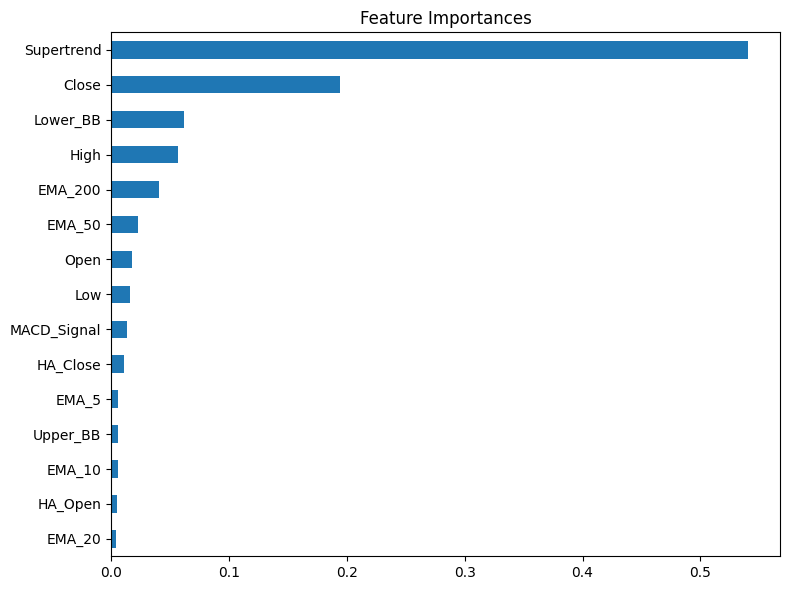

Price,Open,High,Low,Close,Volume,EMA_5,EMA_7,EMA_10,EMA_20,EMA_50,...,Entry,Target,StopLoss,RR,Target_15min,pct_change_3,pct_change_6,pct_change_9,Predicted_15min_Target,Expected_Profit
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-04 14:30:00+05:30,51515.199219,51538.0,51480.0,51482.0,0,51527.0,51537.0,51547.0,51566.0,51597.0,...,,,,,51442.0,-0.000660,-0.000970,-0.001164,51474.729609,-7.270391
2025-04-04 14:33:00+05:30,51484.949219,51495.0,51465.0,51483.0,0,51512.0,51524.0,51535.0,51558.0,51592.0,...,51457.26,51461.67,51645.93,-0.02,51431.0,0.000019,-0.000641,-0.000951,51479.651475,-3.348525
2025-04-04 14:36:00+05:30,51481.449219,51496.0,51458.0,51484.0,0,51503.0,51514.0,51526.0,51551.0,51588.0,...,51458.26,51454.93,51639.47,0.02,51433.0,0.000019,0.000039,-0.000621,51485.451855,1.451855
2025-04-04 14:39:00+05:30,51484.000000,51490.0,51428.0,51435.0,0,51480.0,51494.0,51509.0,51540.0,51582.0,...,51409.28,51439.48,51636.72,-0.13,51394.0,-0.000952,-0.000932,-0.000913,51482.644921,47.644921
2025-04-04 14:42:00+05:30,51429.199219,51457.0,51421.0,51438.0,0,51466.0,51480.0,51496.0,51530.0,51576.0,...,51412.28,51425.22,51640.88,-0.06,51376.0,0.000058,-0.000893,-0.000874,51462.825375,24.825375
2025-04-04 14:45:00+05:30,51436.199219,51452.0,51426.0,51442.0,0,51458.0,51471.0,51487.0,51522.0,51571.0,...,,,,,51430.0,0.000078,0.000136,-0.000816,51468.096663,26.096663
2025-04-04 14:48:00+05:30,51443.351562,51443.0,51398.0,51431.0,0,51449.0,51461.0,51476.0,51513.0,51565.0,...,,,,,51476.0,-0.000214,-0.000136,-0.000078,51455.450169,24.450169
2025-04-04 14:51:00+05:30,51432.800781,51441.0,51409.0,51433.0,0,51444.0,51454.0,51469.0,51506.0,51560.0,...,,,,,51531.0,0.000039,-0.000175,-0.000097,51466.087807,33.087807
2025-04-04 14:54:00+05:30,51434.101562,51448.0,51389.0,51394.0,0,51427.0,51439.0,51455.0,51495.0,51554.0,...,,,,,51523.0,-0.000758,-0.000719,-0.000933,51423.454981,29.454981


In [ ]:
# Combine features and target for correlation
correlation_df = model_data[feature_columns + ['pct_change_3', 'pct_change_6', 'pct_change_9', 'Target_15min']]

# Calculate correlation with the target
correlations = correlation_df.corr()['Target_15min'].sort_values(ascending=False)

# Display top positively/negatively correlated features
print("\nTop correlated features with Target_15min:")
print(correlations.drop('Target_15min').abs().sort_values(ascending=False).head(15))
top_features = correlations.drop('Target_15min').abs().sort_values(ascending=False).head(15).index.tolist()

# Prepare refined training data
X_top = model_data[top_features]
y_top = model_data['Target_15min']

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, shuffle=False, test_size=0.2)
model_top = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
model_top.fit(X_train_top, y_train_top)

# Predict and evaluate
model_data['Predicted_15min_Target'] = model_top.predict(X_top)
model_data['Expected_Profit'] = model_data['Predicted_15min_Target'] - model_data['Close']

# MAE Evaluation
mae_top = mean_absolute_error(y_test_top, model_top.predict(X_test_top))
print(f"Improved MAE on test set: {mae_top:.2f}")
import matplotlib.pyplot as plt

# Plot feature importances
importances = pd.Series(model_top.feature_importances_, index=top_features)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title='Feature Importances')
plt.tight_layout()
plt.show()
# Drop previous prediction columns (if any)
df_3min = df_3min.drop(columns=['Predicted_15min_Target', 'Expected_Profit'], errors='ignore')

# Merge new predictions
df_3min = df_3min.merge(model_data[['Predicted_15min_Target', 'Expected_Profit']],
                        left_index=True, right_index=True, how='left')


df_3min.tail(20)


In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Assuming df_3min already has all indicators
# Step 1: Create Target Column (15-min ahead price)
df_3min['Target_15min'] = df_3min['Close'].shift(-5)

# Step 2: Feature Engineering
# Select feature columns
feature_columns = [
    'Close', 'High', 'Low', 'Open',
    'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
    'ADX', 'ADX_Incr', '+DI', '-DI',
    'Variance', 'MACD', 'MACD_Signal',
    'Supertrend', 'SMHT', 'HA_Close', 'HA_Open',
    'Upper_BB', 'Lower_BB'
]

# Optional: Add price momentum features
df_3min['pct_change_3'] = df_3min['Close'].pct_change(1)
df_3min['pct_change_6'] = df_3min['Close'].pct_change(2)
df_3min['pct_change_9'] = df_3min['Close'].pct_change(3)

# Drop NA rows from shifting
model_data = df_3min.dropna(subset=feature_columns + ['Target_15min'])

# Step 3: Prepare Data
X = model_data[feature_columns + ['pct_change_3', 'pct_change_6', 'pct_change_9']]
y = model_data['Target_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Step 4: Train Model
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict
model_data['Predicted_15min_Target'] = model.predict(X)
model_data['Expected_Profit'] = model_data['Predicted_15min_Target'] - model_data['Close']

# Step 6: Evaluation
mae = mean_absolute_error(y_test, model.predict(X_test))
print(f"MAE on test set: {mae:.2f}")

# Step 7: Attach back to main df (avoid duplicate columns)
df_3min = df_3min.drop(columns=['Predicted_15min_Target', 'Expected_Profit'], errors='ignore')
df_3min = df_3min.merge(model_data[['Predicted_15min_Target', 'Expected_Profit']],
                        left_index=True, right_index=True, how='left')

# Display top signals with prediction
df_signals = df_3min[df_3min['Signal'].str.contains("BUY|SELL", na=False)]
df_signals = df_signals[['Close', 'Signal', 'Predicted_15min_Target', 'Expected_Profit', 'ADX', 'Supertrend']]
df_signals.tail(30)

# Optional: Save results
#df_signals.to_csv("3min_signal_with_predictions.csv", index=False)


MAE on test set: 64.17


<ipython-input-5-8485147f28eb>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Predicted_15min_Target'] = model.predict(X)
<ipython-input-5-8485147f28eb>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Expected_Profit'] = model_data['Predicted_15min_Target'] - model_data['Close']


Price,Close,Signal,Predicted_15min_Target,Expected_Profit,ADX,Supertrend
Datetime,,,,,,
2025-04-04 12:48:00+05:30,51661.0,Strong BUY (4.0),51582.973005,-78.026995,11.0,51559.7
2025-04-04 12:51:00+05:30,51625.0,SELL (-2.5),51569.914582,-55.085418,11.0,51532.1
2025-04-04 12:54:00+05:30,51633.0,SELL (-2.5),51566.886810,-66.113190,11.0,51510.3
2025-04-04 13:06:00+05:30,51690.0,Strong BUY (6.0),51579.631534,-110.368466,10.0,51557.9
2025-04-04 13:09:00+05:30,51666.0,Strong BUY (6.0),51638.464094,-27.535906,11.0,51563.7
2025-04-04 13:15:00+05:30,51620.0,SELL (-2.5),51564.520853,-55.479147,11.0,51489.4
2025-04-04 13:27:00+05:30,51644.0,SELL (-2.5),51568.840084,-75.159916,9.0,51490.8
2025-04-04 13:33:00+05:30,51610.0,SELL (-2.5),51567.427521,-42.572479,8.0,51491.5
2025-04-04 13:36:00+05:30,51616.0,SELL (-2.5),51563.579463,-52.420537,8.0,51480.2
